In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import os
import cupy as cp


class SuperPixels:
    def __init__(self, h, w, l=0, a=0, b=0):
        self.update(h, w, l, a, b)

    def update(self, h, w, l, a, b):
        self.h = h
        self.w = w
        self.l = l
        self.a = a
        self.b = b

In [2]:
def initial_cluster_center(S, img, img_h, img_w, k):
    clusters = []
    for _ in range(k):
        h = np.random.randint(0, img_h)
        w = np.random.randint(0, img_w)
        clusters.append(SuperPixels(h, w, img[h, w, 0], img[h, w, 1], img[h, w, 2]))
    return np.array(clusters)

In [3]:
def assign_pixels_to_cluster(clusters, S, img_lab, img_h, img_w, tag, dis, m):
    for c in (range(len(clusters))):

        current_cluster = clusters[c]
        h_center, w_center = int(current_cluster.h), int(current_cluster.w)
        l_center, a_center, b_center = current_cluster.l, current_cluster.a, current_cluster.b

        for h in range(max(0, h_center - 2*S), min(img_h, h_center + 2*S)):
            for w in range(max(0, w_center - 2*S), min(img_w, w_center + 2*S)):
                l, a, b = img_lab[h, w]
                Dc = math.sqrt((l - l_center) ** 2 + (a - a_center) ** 2 + (b - b_center) ** 2)
                Ds = math.sqrt((h - h_center) ** 2 + (w - w_center) ** 2)
                D = math.sqrt((Dc / m) ** 2 + (Ds / S) ** 2)

                if D < dis[h, w]:
                    dis[h, w] = D
                    tag[(h, w)] = c

def update_cluster_mean(clusters, img, tag):
    for c in range(len(clusters)):
        assigned_pixels = []
        for p, cluster in tag.items():
            if cluster == c:
                assigned_pixels.append(p)
        # assigned_pixels = [p for p, cluster in tag.items() if cluster == c]
        if len(assigned_pixels) == 0:
            continue

        pixels_arr = np.array(assigned_pixels)
        mean_h, mean_w = np.mean(pixels_arr, axis=0).astype(int)

        if 0 <= mean_h < img.shape[0] and 0 <= mean_w < img.shape[1]:
            l, a, b = img[mean_h, mean_w]
            clusters[c].h, clusters[c].w = mean_h, mean_w
            clusters[c].l, clusters[c].a, clusters[c].b = l, a, b

def avg_color_cluster(img, clusters, tag):
    output_image = np.copy(img)

    for p, cluster in tag.items():
        
        output_image[p[0], p[1]] = (clusters[cluster].l, clusters[cluster].a, clusters[cluster].b)

    for c in range(clusters.shape[0]):
        output_image[int(clusters[c].h), int(clusters[c].w)] = (0, 0, 0)

    return output_image

In [7]:
def slic_overall_image(S, img, img_h, img_w, tag, dis, k, m):
    clusters = initial_cluster_center(S, img, img_h, img_w, k)
    for i in range(5):
        # print(i)
        assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
        update_cluster_mean(clusters, img, tag)
    return avg_color_cluster(img, clusters, tag)

In [5]:
def slic_each_iteration(S, img, img_h, img_w, tag, dis, k, m):
    clusters = initial_cluster_center(S, img, img_h, img_w, k)

    for i in range(5): 
        assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
        update_cluster_mean(clusters, img, tag)

        iter_image = avg_color_cluster(img, clusters, tag)
        iter_image_rgb = cv2.cvtColor(iter_image.astype(np.uint8), cv2.COLOR_Lab2RGB)

        plt.imshow(iter_image_rgb)
        plt.axis("off")
        plt.title(f"Iteration {i + 1}")

        plt.savefig(f"iteration_Lab{i+1}.png")

        plt.draw()
        plt.pause(0.5)

    return avg_color_cluster(img, clusters, tag)

In [6]:
def show_the_image(k, m, param):
    image = cv2.imread("frame_0000.jpg")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    image_lab = image_lab.astype(np.int32)

    height, width, _ = image_lab.shape
    num_pixels = height * width

    S = int(math.sqrt(num_pixels / k))
    tag = {}
    dis = np.full((height, width), np.inf)

    if param == 1:
        output_image = slic_overall_image(S, image_lab, height, width, tag, dis, k, m)

        output_image_rgb = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_Lab2RGB)

        plt.imshow(output_image_rgb)
        plt.axis("off")
        plt.savefig("final_output_Lab.png")
        plt.show()
    elif param == 2:
        output_image = slic_each_iteration(S, image_lab, height, width, tag, dis, k, m)


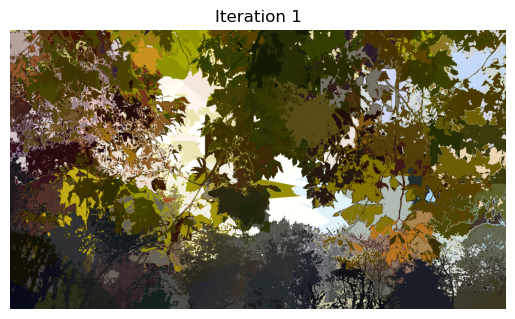

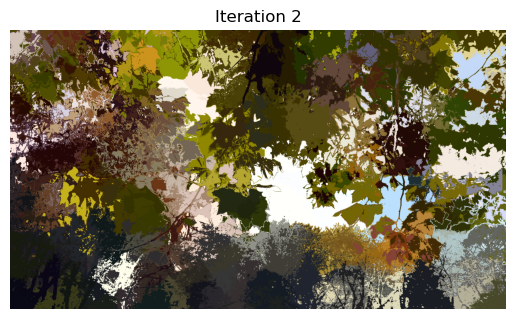

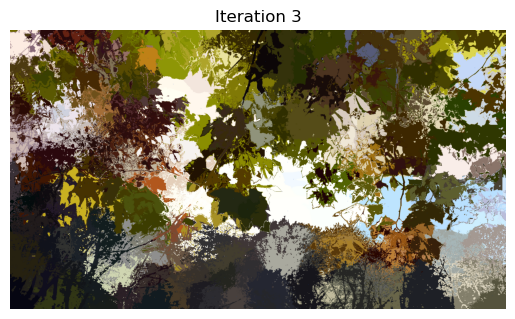

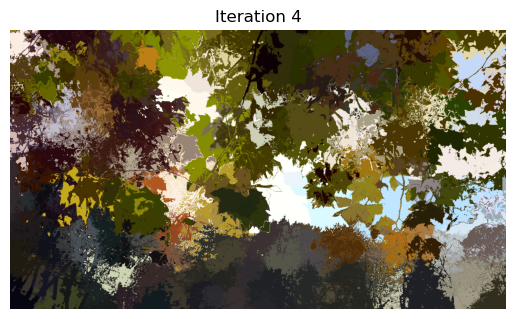

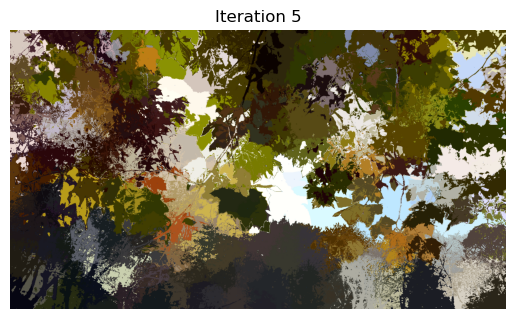

In [40]:
show_the_image(200, 20, 2)

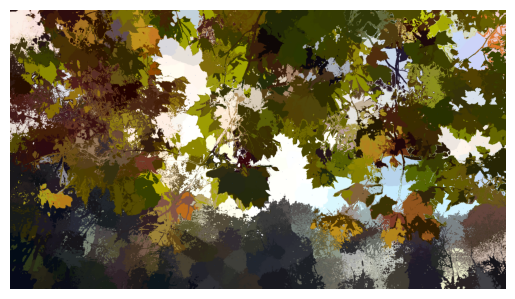

In [41]:
show_the_image(400, 20,1)

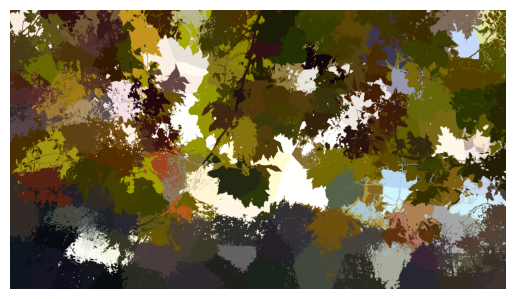

In [42]:
show_the_image(200, 40,1)


In [43]:
def show_the_image_5_2(k, m, param):
    images_list = ["frames/frame_0065.jpg", "frames/frame_0066.jpg", "frames/frame_0067.jpg", "frames/frame_0068.jpg", "frames/frame_0069.jpg", "frames/frame_0070.jpg", "frames/frame_0071.jpg", "frames/frame_0072.jpg", "frames/frame_0073.jpg", "frames/frame_0074.jpg", "frames/frame_0075.jpg"]

    for idx, imagee in enumerate(images_list):
        image = cv2.imread(imagee)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

        image_lab = image_lab.astype(np.int32)

        height, width, _ = image_lab.shape
        num_pixels = height * width

        S = int(math.sqrt(num_pixels / k))
        tag = {}
        dis = np.full((height, width), np.inf)

        output_image = slic_overall_image(S, image_lab, height, width, tag, dis, k, m)

        output_image_rgb = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_Lab2RGB)

        plt.imshow(output_image_rgb)
        plt.axis("off")
        plt.savefig(f"final_output{idx}.jpg")
        plt.pause(0.1)
        plt.clf()

In [ ]:
show_the_image_5_2(500, 20, 1)

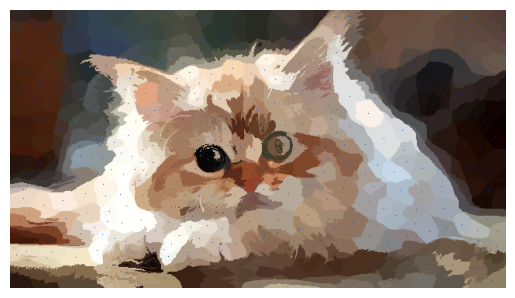

In [11]:
image = cv2.imread("cat.jpg")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

image_lab = image_lab.astype(np.int32)

height, width, _ = image_lab.shape
num_pixels = height * width

k = 500
m = 20

S = int(math.sqrt(num_pixels / k))
tag = {}
dis = np.full((height, width), np.inf)

output_image = slic_overall_image(S, image_lab, height, width, tag, dis, k, m)

output_image_rgb = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_Lab2RGB)

plt.imshow(output_image_rgb)
plt.axis("off")
plt.savefig("final_output_cat.jpg")
plt.show()

In [ ]:
def update_cluster_mean_5_3(clusters, img, tag):
    total_change = 0
    for c in range(len(clusters)):
        assigned_pixels = []
        for p, cluster in tag.items():
            if cluster == c:
                assigned_pixels.append(p)

        if len(assigned_pixels) == 0:
            continue

        pixels_arr = np.array(assigned_pixels)
        mean_h, mean_w = np.mean(pixels_arr, axis=0).astype(int)

        if 0 <= mean_h < img.shape[0] and 0 <= mean_w < img.shape[1]:
            l, a, b = img[mean_h, mean_w]
            total_change += abs(mean_h - clusters[c].h) + abs(mean_w - clusters[c].w)
            clusters[c].h, clusters[c].w = mean_h, mean_w
            clusters[c].l, clusters[c].a, clusters[c].b = l, a, b
    return total_change

In [ ]:
def slic_overall_image_5_3(S, img, img_h, img_w, tag, dis, k, m, iterations, clusters, tolerance):
    for i in range(iterations):
        print(f"Iteration {i + 1}")
        assign_pixels_to_cluster(clusters, S, img, img_h, img_w, tag, dis, m)
        total_change = update_cluster_mean_5_3(clusters, img, tag)

        # If the change in cluster centers is below the tolerance, break the loop early
        print(total_change)
        if total_change < tolerance:
            print(f"Convergence reached at iteration {i + 1}")
            break

    return avg_color_cluster(img, clusters, tag), img, clusters, tag, dis


In [ ]:
def show_the_image_5_3(k, m, param):
    images_list = ["frame_0065.jpg", "frame_0066.jpg", "frame_0067.jpg", "frame_0068.jpg", "frame_0069.jpg", "frame_0070.jpg", "frame_0071.jpg", "frame_0072.jpg", "frame_0073.jpg", "frame_0074.jpg", "frame_0075.jpg"]
    iterations = 10
    tolerance = 150  # Set a small tolerance threshold

    for idx in range(11):

        image = cv2.imread(images_list[idx])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)
        image_lab = image_lab.astype(np.int32)

        if idx == 0:
            height, width, _ = image_lab.shape
            num_pixels = height * width

            S = int(math.sqrt(num_pixels / k))
            tag = {}
            dis = np.full((height, width), np.inf)

            clusters = initial_cluster_center(S, image_lab, height, width, k)

        output_image, image_lab, clusters, tag, dis = slic_overall_image_5_3(S, image_lab, height, width, tag, dis, k, m, iterations, clusters, tolerance)

        output_image_rgb = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_Lab2RGB)

        plt.imshow(output_image_rgb)
        plt.axis("off")
        plt.savefig(f"final_output_reduced_iter{idx}.jpg")
        plt.pause(0.1)
        plt.clf()


In [ ]:
show_the_image_5_3(300, 20, 1)

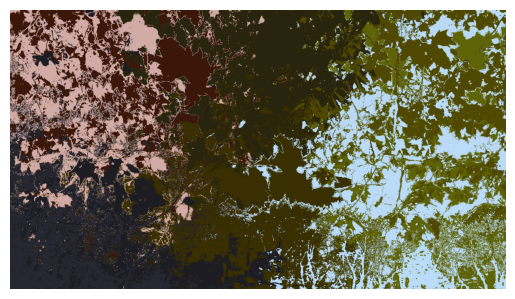

In [8]:
show_the_image(10, 20, 1)

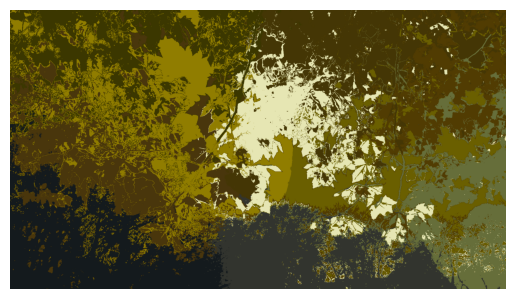

In [9]:
show_the_image(10, 40, 1)